In [1]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [3]:
# 2. SAFE CSV LOADING (handling malformed lines automatically)
def safe_read_csv(path):
    rows = []
    with open(path, "r", errors="ignore") as f:
        for line in f:
            parts = line.strip().rsplit(",", 1)
            if len(parts) == 2:
                rows.append(parts)
    return pd.DataFrame(rows, columns=["URL", "Label"])

df = safe_read_csv("/content/drive/MyDrive/phishing_site_urls.csv")

df = df.dropna()
df = df[df["URL"].str.len() > 4]

print("Loaded rows:", len(df))

Loaded rows: 549343


In [4]:
# 3. FEATURE EXTRACTION
def extract_features(url):
    parsed = urlparse(url)
    hostname = parsed.netloc

    return {
        "url_length": len(url),
        "hostname_length": len(hostname),
        "num_dots": url.count("."),
        "num_hyphens": url.count("-"),
        "num_slashes": url.count("/"),
        "num_digits": sum(c.isdigit() for c in url),
        "has_ip": 1 if re.match(r"^\d+\.\d+\.\d+\.\d+$", hostname) else 0,
        "is_https": 1 if parsed.scheme == "https" else 0,
        "suspicious_words": sum(w in url.lower() for w in ["login","verify","update","secure","bank","account"])
    }

In [5]:
# Apply feature extraction
features = df["URL"].apply(extract_features)
features = pd.DataFrame(features.tolist())

In [6]:
# Combine with label column
data = pd.concat([features, df["Label"]], axis=1)

In [7]:
# Encode labels
data["Label"] = data["Label"].map({"good":0, "bad":1, "legitimate":0, "phishing":1}).fillna(1).astype(int)

In [9]:
# 4. SPLIT DATASET
X = data.drop("Label", axis=1)
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 5. TRAIN RANDOM FOREST MODEL
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "phishing_model.joblib")

['phishing_model.joblib']

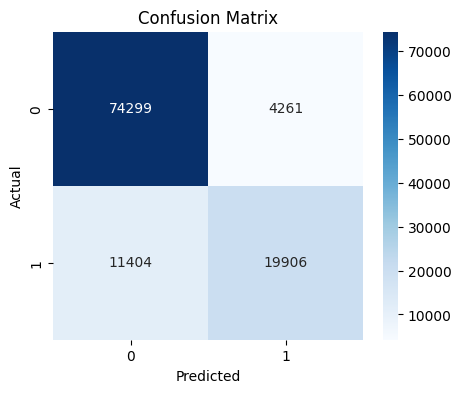


Model Performance:
Accuracy: 0.857422408300719
Precision: 0.8236851905490958
Recall: 0.6357713190673906


In [12]:
# 6. EVALUATION
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nModel Performance:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)

In [14]:
# 7. URL PREDICTION FUNCTION
def predict_url(url):
    f = extract_features(url)
    df_f = pd.DataFrame([f])
    pred = model.predict(df_f)[0]
    return "PHISHING 🔴" if pred == 1 else "LEGITIMATE 🟢"

# Test real-time prediction
test_url = "http://secure-update-login-bank.verify-account.com"
print("\nTest URL:", test_url)
print("Prediction:", predict_url(test_url))

# Test real-time prediction
test_url = " http://instagrarn-login-help.com"
print("\nTest URL:", test_url)
print("Prediction:", predict_url(test_url))


Test URL: http://secure-update-login-bank.verify-account.com
Prediction: PHISHING 🔴

Test URL:  http://instagrarn-login-help.com
Prediction: LEGITIMATE 🟢
